# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import json
% matplotlib inline

# Read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
#############################
######### Clean Data ########
#############################

# Transform duration days into hours
portfolio['duration'] = portfolio['duration'].apply(lambda x: x*24)

# Keep only year from date
profile['became_member_on'] = profile['became_member_on'].apply(lambda x: (pd.to_datetime(str(x),format='%Y%m%d')).year )

# Remove invalid rows (age == 118)
invalidIDs = profile[profile.age == 118]['id'].values.tolist()
profile.drop(profile[profile.id.isin(invalidIDs)].index, inplace=True)
transcript.drop(transcript[transcript.person.isin(invalidIDs)].index, inplace = True)

# Clean transcript - replace offer_id with offer id
def refactor(offer):
    if("offer_id" in offer.keys()):
        newOffer = dict()
        newOffer["offer id"] = offer["offer_id"];
        newOffer["reward"] = offer["reward"];
        return newOffer

    return offer

transcript['value'] = transcript['value'].apply(refactor)

# Unique persons
persons = transcript.person.unique()

# Find persons that received offers
offer_received_persons=transcript[transcript['event'] == 'offer received']
unique_persons_received_offer = offer_received_persons['person'].unique()

# Find persons that viewed offers
offer_viewed_persons=transcript[transcript['event'] == 'offer viewed']
unique_persons_viewed_offer = offer_viewed_persons['person'].unique()

# Find persons that made at least a transaction
made_transaction_persons=transcript[transcript['event'] == 'transaction']
unique_persons_made_transaction = made_transaction_persons['person'].unique()

# Remove people that did not receive any offer
persons_without_offer_received = np.setdiff1d(persons,unique_persons_received_offer)
person_without_offer_received_rows = transcript.loc[transcript['person'].isin(persons_without_offer_received)].index
transcript.drop(transcript.loc[transcript['person'].isin(persons_without_offer_received)].index,inplace=True)

# Remove people that did not view any offer 
persons_without_offer_viewed = np.setdiff1d(persons,unique_persons_viewed_offer)
persons_without_offer_viewed_rows = transcript.loc[transcript['person'].isin(persons_without_offer_viewed)].index
transcript.drop(transcript.loc[transcript['person'].isin(persons_without_offer_viewed)].index,inplace=True)

# Remove people that did not make transactions (and did not receive offer - previous step)
persons_without_transaction = np.setdiff1d(persons,unique_persons_made_transaction)
persons_without_transaction_rows = transcript.loc[transcript['person'].isin(persons_without_transaction)].index
transcript.drop(transcript.loc[transcript['person'].isin(persons_without_transaction)].index,inplace=True)



In [3]:
# Find and return unique persons
def findUniquePersons():
    return transcript['person'].unique()

# Get all events for a specific person
def getEventsForPerson(person):
    events = transcript[transcript['person'] == person]
    events.reset_index(inplace=True)
    return events

# Get offer type for a specific offer id
def getOfferType(offerId):
    return portfolio.loc[portfolio['id'] == offerId, 'offer_type'].values[0]

# Get duration of an offer, based on offer id
def findDurationOffer(offerId):
     return portfolio.loc[portfolio.id == offerId,'duration'].values[0]

# Find if there is any 'transaction' event between 2 given indexes of a provided dataframe  
# where [..,Idx1,..,Idx2,..] and Idx1 < Idx2
def isThereAnyTransactionBetweenIndexes(Idx1, Idx2, df):
    if(Idx2 > Idx1):
        for idx in range(Idx1+1, Idx2):
            event = df.iloc[idx]
            if(event['event']=='transaction'):
                return True
    return False

In [4]:
# Function that identifies if the persons provided have completed the offers
# they received and returns a new dataframe with the following columns
# ["Person", "Offer id", "Offer type", "Offer completed"]
def getOfferCompletionForPersons(persons, logProgress=False):    
    # Create new dataframe to store final result
    column_names = ["Person", "Offer id", "Offer type", "Offer completed"]
    df = pd.DataFrame(columns = column_names)
    id = 0;
    for person in persons: 
        id=id+1;
        
        if(logProgress):{
        # Print progress
            print("Progress: %d/%d" %(id,len(persons)))
        }
            
        # Find all events related to provided person  
        events = getEventsForPerson(person)
        
        # Drop not needed columns
        events.drop(['index','person'], axis=1, inplace=True)

        # Initialize lists to keep already examined indexes
        recEventsIdxList = []
        viewEventsIdxList = []
        complEventsIdxList = []
    
        # Create a dictionary of offerIds and their duration
        offerIds = portfolio['id'].unique().tolist()
        offerDurationDict = dict()
        for offerId in offerIds:
            duration = findDurationOffer(offerId)
            offerDurationDict[offerId] = duration

        # Get all indexes related to "offer received"
        recEvents = events.loc[events['event'] == "offer received"].index.values

        for recIdx in recEvents:
            recEvent = events.iloc[recIdx]
            currRecEventIdx = currViewEventIdx = currComplEventIdx = -1
            currRecEventTime = recEvent['time']
            offerId = recEvent['value']['offer id']
            currRecEventIdx = recIdx
    
            # if offer is of type Bogo or Discount
            if(getOfferType(offerId) in ('bogo','discount')):
                # Get all indexes related to "offer completed"
                complEventIdxs = events.loc[events['event'] == "offer completed"].index.values
            
                for complIdx in complEventIdxs:
                    event = events.iloc[complIdx]
                    if(event['value']['offer id'] == offerId) and complIdx not in complEventsIdxList:
                        currComplEventIdx = complIdx;
                        complEventsIdxList.append(complIdx);
                        break;

                viewEventsIdxs = events.loc[events['event'] == "offer viewed"].index.values
                for viewEventIdx in viewEventsIdxs:
                    event = events.iloc[viewEventIdx]
                    if(event['value']['offer id'] == offerId and viewEventIdx not in viewEventsIdxList):
                        currViewEventIdx = viewEventIdx;
                        viewEventsIdxList.append(viewEventIdx);
                        break;

                # Check if no transaction event is between offer received & offer viewed
                otherFail = isThereAnyTransactionBetweenIndexes(currRecEventIdx,currViewEventIdx,events)
                    
                if(currRecEventIdx < currViewEventIdx < currComplEventIdx and not otherFail):
                    completed = True;
                else:
                    completed = False;
            
                df2 = {'Person': person, 'Offer id': offerId, 'Offer type': getOfferType(offerId), 'Offer completed':completed}
                df = df.append(df2, ignore_index = True)
            # if offer is of type Informational
            else:
                viewEventsIdxs = events.loc[events['event'] == "offer viewed"].index.values
                completed = False;
                for viewEventIdx in viewEventsIdxs:
                    event = events.iloc[viewEventIdx]
                
                    if(event['value']['offer id'] == offerId and viewEventIdx not in viewEventsIdxList):
                        currViewEventIdx = viewEventIdx
                        viewEventsIdxList.append(viewEventIdx)
                        transactEventsIdxs = events.loc[events['event'] == "transaction"].index.values
                        currTransEventTime = 0;
                
                        # Check if no transaction event is between offer received & offer viewed
                        otherFail = isThereAnyTransactionBetweenIndexes(currRecEventIdx,currViewEventIdx,events)
                
                        if(not otherFail):
                            for transactEventsIdx in transactEventsIdxs:
                                if(transactEventsIdx > currViewEventIdx):
                                    trEvent = events.iloc[transactEventsIdx]
                                    currTransEventTime = trEvent['time']
                                    break
                
                            if(((currTransEventTime-currRecEventIdx) <= offerDurationDict[offerId]) & currViewEventIdx > currRecEventIdx):
                                completed = True;
                            else:
                                completed = False;
                            
                        
                df2 = {'Person': person, 'Offer id': offerId, 'Offer type': getOfferType(offerId), 'Offer completed':completed}
                df = df.append(df2, ignore_index = True)
                    
    return df
    

In [5]:
# Get unique person ids
persons = findUniquePersons()

# Get dataframe regarding offer completion for unique persons
df = getOfferCompletionForPersons(persons,True)

# Modify dataframe by adding & removing columns
df = df.merge(profile, left_on='Person', right_on='id')
df.drop(['Person', 'Offer id', 'id'], axis=1,  inplace=True)

# Change 'Offer completed' column values from (False,True) to (0,1)
df['Offer completed'] = df['Offer completed'].astype(int)

# Save df as "offer_data"
df.to_pickle('offer_data')

Progress: 1/14352
Progress: 2/14352
Progress: 3/14352


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4/14352
Progress: 5/14352
Progress: 6/14352
Progress: 7/14352
Progress: 8/14352
Progress: 9/14352
Progress: 10/14352
Progress: 11/14352
Progress: 12/14352
Progress: 13/14352
Progress: 14/14352
Progress: 15/14352
Progress: 16/14352
Progress: 17/14352
Progress: 18/14352
Progress: 19/14352
Progress: 20/14352
Progress: 21/14352
Progress: 22/14352
Progress: 23/14352
Progress: 24/14352
Progress: 25/14352
Progress: 26/14352
Progress: 27/14352
Progress: 28/14352
Progress: 29/14352
Progress: 30/14352
Progress: 31/14352
Progress: 32/14352
Progress: 33/14352
Progress: 34/14352
Progress: 35/14352
Progress: 36/14352
Progress: 37/14352
Progress: 38/14352
Progress: 39/14352
Progress: 40/14352
Progress: 41/14352
Progress: 42/14352
Progress: 43/14352
Progress: 44/14352
Progress: 45/14352
Progress: 46/14352
Progress: 47/14352
Progress: 48/14352
Progress: 49/14352
Progress: 50/14352
Progress: 51/14352
Progress: 52/14352
Progress: 53/14352
Progress: 54/14352
Progress: 55/14352
Progress: 56/14352

In [6]:
# Load clean data to df
df = pd.read_pickle('offer_data')

# # Change 'Offer completed' column values from (False,True) to (0,1)
# df['Offer completed'] = df['Offer completed'].astype(int)

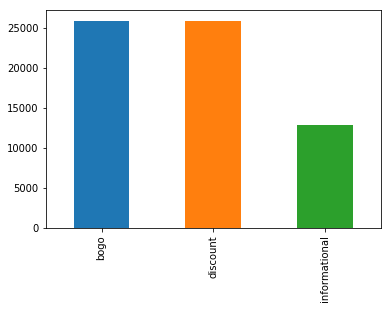

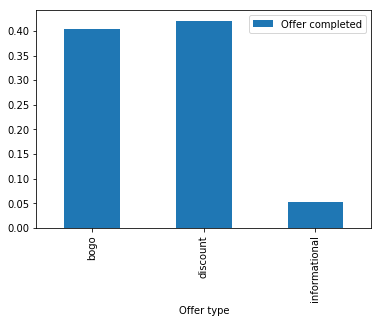

In [7]:
import matplotlib.pyplot as mp

# Check how many offers from each type were received in total
df['Offer type'].value_counts().plot(kind='bar')

# Find how many of each offer type were completed successfully
df1 = df[['Offer type','Offer completed']]
df1.groupby(['Offer type']).mean().plot(kind='bar')

# ======================================================================================================
# Outcome
# ======================================================================================================
# There had been received in total:
# BOGO offers : 25861
# DISCOUNT offers : 25803
# INFORMATIONAL offers : 12907
#
# Completion rate for each offer type:
# BOGO offers : 40.3%
# DISCOUNT offers : 42%
# INFORMATIONAL offers : 5.3%
# ======================================================================================================


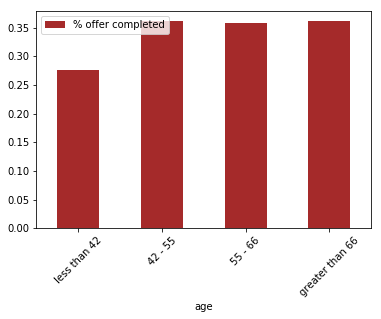

In [8]:
# ------------------------------------------------
# Check Dependency between Age & Offer completion
# ------------------------------------------------
quantiles = df['age'].quantile([.25, .5, .75])
dfQuant1 = df.loc[df.age < quantiles[.25]]
dfQuant2 = df.loc[(quantiles[.25] < df.age) & (df.age < quantiles[.5])]
dfQuant3 = df.loc[(quantiles[.5] < df.age) & (df.age < quantiles[.75])]
dfQuant4 = df.loc[df.age > quantiles[.75]]

dfQuant1Mean = dfQuant1['Offer completed'].mean()
dfQuant2Mean = dfQuant2['Offer completed'].mean()
dfQuant3Mean = dfQuant3['Offer completed'].mean()
dfQuant4Mean = dfQuant4['Offer completed'].mean()


df1 = pd.DataFrame({'age':['less than 42','42 - 55' ,'55 - 66' ,'greater than 66' ], '% offer completed':[dfQuant1Mean,dfQuant2Mean,dfQuant3Mean,dfQuant4Mean]})
ax = df1.plot.bar(x='age', y='% offer completed', rot=45, color="brown")

# Outcome
# =====================================================================
# customers with age < 42 years old => offers completed 27.5%
# customers with 55 > age > 42 years old => offers completed 36.1%
# customers with 66 > age > 55 years old =>offers completed 35.8%
# customers with age > 66 years old => offers completed 36.1%
# =====================================================================


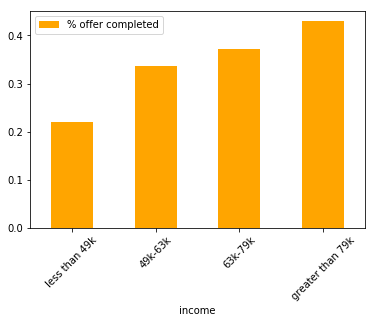

In [9]:
# --------------------------------------------------
# Check Dependency betweem Income & Offer completion
# --------------------------------------------------
quantiles = df['income'].quantile([.25, .5, .75])

dfQuant1 = df.loc[df.income < quantiles[.25]]
dfQuant2 = df.loc[(quantiles[.25] < df.income) & (df.income < quantiles[.5])]
dfQuant3 = df.loc[(quantiles[.5] < df.income) & (df.income < quantiles[.75])]
dfQuant4 = df.loc[df.income > quantiles[.75]]

dfQuant1Mean = dfQuant1['Offer completed'].mean()
dfQuant2Mean = dfQuant2['Offer completed'].mean()
dfQuant3Mean = dfQuant3['Offer completed'].mean()
dfQuant4Mean = dfQuant4['Offer completed'].mean()

df1 = pd.DataFrame({'income':['less than 49k','49k-63k','63k-79k','greater than 79k'], '% offer completed':[dfQuant1Mean,dfQuant2Mean,dfQuant3Mean,dfQuant4Mean]})

ax = df1.plot.bar(x='income', y='% offer completed', rot=45, color = 'orange')

# Outcome
# =====================================================================
# customers with salary < 49.000 completed 22.1% of offers
# customers with  49.000 < salary < 63000 completed 33.7% of offers
# customers with 63000 < salary < 79.000 completed 37.1% of offers
# customers with salary > 79000 completed 43% of offers
# =====================================================================


Text(0,0.5,'Offer(%) completion')

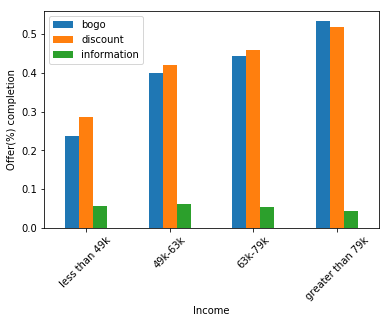

In [10]:
# ------------------------------------------------------------------
# Check Dependency betweenIncome & Offer completion (per offer type)
# ------------------------------------------------------------------
# Keep the selected columns
df1 = df[['Offer type','Offer completed','age','income']]

####################
# Offer type: BOGO #
####################
bogoOfferResults = list()

df2 = df1.loc[(df1['Offer type'] == 'bogo') & (df1['income'] < 49000) ]
bogoOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'bogo') & (df1['income'] > 49000) & (df1['income'] < 63000) ]
bogoOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'bogo') & (df1['income'] > 63000) & (df1['income'] < 79000) ]
bogoOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'bogo') & (df1['income'] > 79000)]
bogoOfferResults.append(df2['Offer completed'].mean())

# Outcome
# =============================================================================================
# 23.7% of customers that received a bogo offer with income < 49000 completed the offer
# 39.8% of customers that received a bogo offer with 63000 > income > 49000 completed the offer
# 44.2% of customers that received a bogo offer with 79000 > income > 63000 completed the offer
# 53.3% of customers that received a bogo offer with income > 79000 completed the offer
# =============================================================================================

########################
# Offer type: DISCOUNT #
########################
discountOfferResults = list()

df2 = df1.loc[(df1['Offer type'] == 'discount') & (df1['income'] < 49000) ]
discountOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'discount') & (df1['income'] > 49000) & (df1['income'] < 63000) ]
discountOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'discount') & (df1['income'] > 63000) & (df1['income'] < 79000) ]
discountOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'discount') & (df1['income'] > 79000)]
discountOfferResults.append(df2['Offer completed'].mean())

# Outcome
# =================================================================================================
# 28.5% of customers that received a discount offer with income < 49000 completed the offer
# 41.9% of customers that received a discount offer with 63000 > income > 49000 completed the offer
# 45.7% of customers that received a discount offer with 79000 > income > 63000 completed the offer
# 51.9% of customers that received a discount offer with income > 79000 completed the offer
# =================================================================================================

#############################
# Offer type: INFORMATIONAL #
#############################
informationalOfferResults = list()

df2 = df1.loc[(df1['Offer type'] == 'informational') & (df1['income'] < 49000) ]
informationalOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'informational') & (df1['income'] > 49000) & (df1['income'] < 63000) ]
informationalOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'informational') & (df1['income'] > 63000) & (df1['income'] < 79000) ]
informationalOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'informational') & (df1['income'] > 79000)]
informationalOfferResults.append(df2['Offer completed'].mean())

# Outcome
# ======================================================================================================
# 5.5% of customers that received an informational offer with income < 49000 completed the offer
# 6.1% of customers that received an informational offer with 63000 > income > 49000 completed the offer
# 5.5% of customers that received an informational offer with 79000 > income > 63000 completed the offer
# 4.3% of customers that received an informational offer with income > 79000 completed the offer
# ======================================================================================================

df1 = pd.DataFrame({'bogo':bogoOfferResults,
                   'discount':discountOfferResults,
                   'information':informationalOfferResults
                   }, index = ['less than 49k','49k-63k','63k-79k','greater than 79k'])
ax = df1.plot.bar(rot=45)
plt.xlabel("Income")
plt.ylabel("Offer(%) completion")    


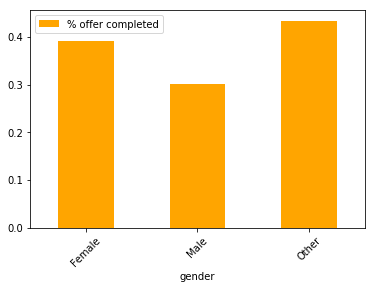

In [11]:
# ----------------------------------------------------------
# Check dependency between offer completion and gender type
# ----------------------------------------------------------
df1 = df[['Offer completed', 'gender']]
df2 = df1.groupby(['gender']).mean().reset_index()

femaleCompl = df2.loc[df2['gender'] == 'F']['Offer completed'].values[0]
maleCompl = df2.loc[df2['gender'] == 'M']['Offer completed'].values[0]
otherCompl = df2.loc[df2['gender'] == 'O']['Offer completed'].values[0]

df2 = pd.DataFrame({'gender':['Female','Male','Other'], '% offer completed':[femaleCompl, maleCompl, otherCompl]})
ax = df2.plot.bar(x='gender', y='% offer completed', rot=45, color = 'orange')


# Outcome
# ===========================================================
# 39% of female customers that received an offer completed it
# 30% of male customers that received an offer completed it
# 43% of other customers that received offer completed it
# ===========================================================



Text(0,0.5,'Bogo Offer completion (%)')

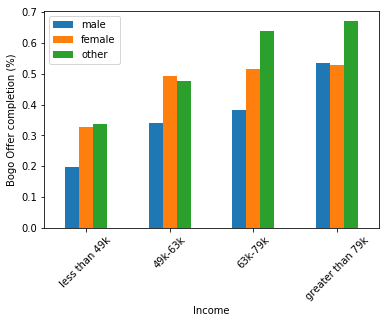

In [12]:
# ---------------------------------------------
# Check Income & Offer completion (per gender)
# ---------------------------------------------

# Keep the selected columns
df1 = df[['Offer type','Offer completed','age','income','gender']]

###################################
# Gender: Male | Offer type: BOGO #
###################################
maleOfferResults = list()

df2 = df1.loc[(df1['Offer type'] == 'bogo') & (df1['income'] < 49000) & (df1['gender'] == 'M')]
maleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'bogo') & (df1['income'] > 49000) & (df1['income'] < 63000) & (df1['gender'] == 'M') ]
maleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'bogo') & (df1['income'] > 63000) & (df1['income'] < 79000) & (df1['gender'] == 'M') ]
maleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'bogo') & (df1['income'] > 79000) & (df1['gender'] == 'M')]
maleOfferResults.append(df2['Offer completed'].mean())

# Outcome
# ====================================================================================================
# 19.9% of 'male' customers that received a bogo offer with income < 49000 completed the offer
# 34.0% of 'male' customers that received a bogo offer with 63000 > income > 49000 completed the offer
# 38.3% of 'male' customers that received a bogo offer with 79000 > income > 63000 completed the offer
# 53.6% of 'male' customers that received a bogo offer with income > 79000 completed the offer
# ====================================================================================================


#####################################
# Gender: Female | Offer type: BOGO #
#####################################
femaleOfferResults = list()

df2 = df1.loc[(df1['Offer type'] == 'bogo') & (df1['income'] < 49000) & (df1['gender'] == 'F')]
femaleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'bogo') & (df1['income'] > 49000) & (df1['income'] < 63000) & (df1['gender'] == 'F') ]
femaleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'bogo') & (df1['income'] > 63000) & (df1['income'] < 79000) & (df1['gender'] == 'F') ]
femaleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'bogo') & (df1['income'] > 79000) & (df1['gender'] == 'F')]
femaleOfferResults.append(df2['Offer completed'].mean())

# Outcome
# ======================================================================================================
# 32.7% of 'female' customers that received a bogo offer with income < 49000 completed the offer
# 49.4% of 'female' customers that received a bogo offer with 63000 > income > 49000 completed the offer
# 51.4% of 'female' customers that received a bogo offer with 79000 > income > 63000 completed the offer
# 52.9% of 'female' customers that received a bogo offer with income > 79000 completed the offer
# ======================================================================================================


####################################
# Gender: Other | Offer type: BOGO #
####################################
otherOfferResults = list()

df2 = df1.loc[(df1['Offer type'] == 'bogo') & (df1['income'] < 49000) & (df1['gender'] == 'O')]
otherOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'bogo') & (df1['income'] > 49000) & (df1['income'] < 63000) & (df1['gender'] == 'O') ]
otherOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'bogo') & (df1['income'] > 63000) & (df1['income'] < 79000) & (df1['gender'] == 'O') ]
otherOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'bogo') & (df1['income'] > 79000) & (df1['gender'] == 'O')]
otherOfferResults.append(df2['Offer completed'].mean())


# Outcome
# ===============================================================================================================
# 33.7% of 'other' customers that received an informational offer with income < 49000 completed the offer
# 47.7% of 'other' customers that received an informational offer with 63000 > income > 49000 completed the offer
# 63.7% of 'other' customers that received an informational offer with 79000 > income > 63000 completed the offer
# 67.1% of 'other' customers that received an informational offer with income > 79000 completed the offer
# ===============================================================================================================


df1 = pd.DataFrame({'male':maleOfferResults,
                   'female':femaleOfferResults,
                   'other':otherOfferResults
                   }, index = ['less than 49k','49k-63k','63k-79k','greater than 79k'])
ax = df1.plot.bar(rot=45)
plt.xlabel("Income")
plt.ylabel("Bogo Offer completion (%)")   



Text(0,0.5,'Discount Offer completion (%)')

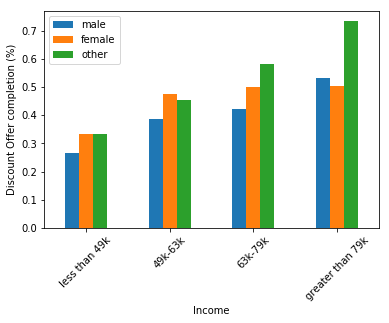

In [13]:
# ---------------------------------------------
# Check Income & Offer completion (per gender)
# ---------------------------------------------

# Keep the selected columns
df1 = df[['Offer type','Offer completed','age','income','gender']]

#######################################
# Gender: Male | Offer type: DISCOUNT #
#######################################
maleOfferResults = list()

df2 = df1.loc[(df1['Offer type'] == 'discount') & (df1['income'] < 49000) & (df1['gender'] == 'M')]
maleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'discount') & (df1['income'] > 49000) & (df1['income'] < 63000) & (df1['gender'] == 'M') ]
maleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'discount') & (df1['income'] > 63000) & (df1['income'] < 79000) & (df1['gender'] == 'M') ]
maleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'discount') & (df1['income'] > 79000) & (df1['gender'] == 'M')]
maleOfferResults.append(df2['Offer completed'].mean())

# Outcome
# ========================================================================================================
# 26.4% of 'male' customers that received a discount offer with income < 49000 completed the offer
# 38.5% of 'male' customers that received a discount offer with 63000 > income > 49000 completed the offer
# 42.3% of 'male' customers that received a discount offer with 79000 > income > 63000 completed the offer
# 53.3% of 'male' customers that received a discount offer with income > 79000 completed the offer
# ========================================================================================================


#########################################
# Gender: Female | Offer type: DISCOUNT #
#########################################
femaleOfferResults = list()

df2 = df1.loc[(df1['Offer type'] == 'discount') & (df1['income'] < 49000) & (df1['gender'] == 'F')]
femaleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'discount') & (df1['income'] > 49000) & (df1['income'] < 63000) & (df1['gender'] == 'F') ]
femaleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'discount') & (df1['income'] > 63000) & (df1['income'] < 79000) & (df1['gender'] == 'F') ]
femaleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'discount') & (df1['income'] > 79000) & (df1['gender'] == 'F')]
femaleOfferResults.append(df2['Offer completed'].mean())

# Outcome
# ==========================================================================================================
# 33.5% of 'female' customers that received a discount offer with income < 49000 completed the offer
# 47.4% of 'female' customers that received a discount offer with 63000 > income > 49000 completed the offer
# 50.0% of 'female' customers that received a discount offer with 79000 > income > 63000 completed the offer
# 50.4% of 'female' customers that received a discount offer with income > 79000 completed the offer
# ==========================================================================================================


########################################
# Gender: Other | Offer type: DISCOUNT #
########################################
otherOfferResults = list()

df2 = df1.loc[(df1['Offer type'] == 'discount') & (df1['income'] < 49000) & (df1['gender'] == 'O')]
otherOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'discount') & (df1['income'] > 49000) & (df1['income'] < 63000) & (df1['gender'] == 'O') ]
otherOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'discount') & (df1['income'] > 63000) & (df1['income'] < 79000) & (df1['gender'] == 'O') ]
otherOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'discount') & (df1['income'] > 79000) & (df1['gender'] == 'O')]
otherOfferResults.append(df2['Offer completed'].mean())


# Outcome
# # ==========================================================================================================
# 33.3% of 'other' customers that received an discount offer with income < 49000 completed the offer
# 45.4% of 'other' customers that received an discount offer with 63000 > income > 49000 completed the offer
# 58.0% of 'other' customers that received an discount offer with 79000 > income > 63000 completed the offer
# 73.4% of 'other' customers that received an discount offer with income > 79000 completed the offer
# # ==========================================================================================================



df1 = pd.DataFrame({'male':maleOfferResults,
                   'female':femaleOfferResults,
                   'other':otherOfferResults
                   }, index = ['less than 49k','49k-63k','63k-79k','greater than 79k'])
ax = df1.plot.bar(rot=45)
plt.xlabel("Income")
plt.ylabel("Discount Offer completion (%)")   



Text(0,0.5,'Informational Offer completion (%)')

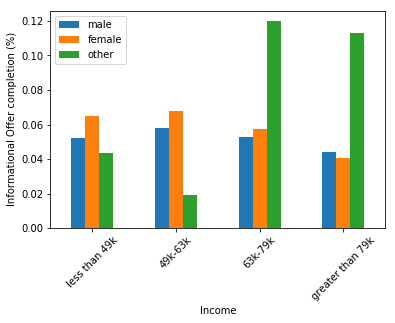

In [14]:
# ---------------------------------------------
# Check Income & Offer completion (per gender)
# ---------------------------------------------

# Keep the selected columns
df1 = df[['Offer type','Offer completed','age','income','gender']]

############################################
# Gender: Male | Offer type: INFORMATIONAL #
############################################
maleOfferResults = list()

df2 = df1.loc[(df1['Offer type'] == 'informational') & (df1['income'] < 49000) & (df1['gender'] == 'M')]
maleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'informational') & (df1['income'] > 49000) & (df1['income'] < 63000) & (df1['gender'] == 'M') ]
maleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'informational') & (df1['income'] > 63000) & (df1['income'] < 79000) & (df1['gender'] == 'M') ]
maleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'informational') & (df1['income'] > 79000) & (df1['gender'] == 'M')]
maleOfferResults.append(df2['Offer completed'].mean())

# Outcome
# ========================================================================================================
# 05.2% of 'male' customers that received an informational offer with income < 49000 completed the offer
# 05.8% of 'male' customers that received an informational offer with 63000 > income > 49000 completed the offer
# 05.3% of 'male' customers that received an informational offer with 79000 > income > 63000 completed the offer
# 04.4% of 'male' customers that received an informational offer with income > 79000 completed the offer
# ========================================================================================================


##############################################
# Gender: Female | Offer type: INFORMATIONAL #
##############################################
femaleOfferResults = list()

df2 = df1.loc[(df1['Offer type'] == 'informational') & (df1['income'] < 49000) & (df1['gender'] == 'F')]
femaleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'informational') & (df1['income'] > 49000) & (df1['income'] < 63000) & (df1['gender'] == 'F') ]
femaleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'informational') & (df1['income'] > 63000) & (df1['income'] < 79000) & (df1['gender'] == 'F') ]
femaleOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'informational') & (df1['income'] > 79000) & (df1['gender'] == 'F')]
femaleOfferResults.append(df2['Offer completed'].mean())

# Outcome
# ==========================================================================================================
# 06.4% of 'female' customers that received an informational offer with income < 49000 completed the offer
# 06.8% of 'female' customers that received an informational offer with 63000 > income > 49000 completed the offer
# 05.7% of 'female' customers that received an informational offer with 79000 > income > 63000 completed the offer
# 04.1% of 'female' customers that received an informational offer with income > 79000 completed the offer
# ==========================================================================================================


#############################################
# Gender: Other | Offer type: INFORMATIONAL #
#############################################
otherOfferResults = list()

df2 = df1.loc[(df1['Offer type'] == 'informational') & (df1['income'] < 49000) & (df1['gender'] == 'O')]
otherOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'informational') & (df1['income'] > 49000) & (df1['income'] < 63000) & (df1['gender'] == 'O') ]
otherOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'informational') & (df1['income'] > 63000) & (df1['income'] < 79000) & (df1['gender'] == 'O') ]
otherOfferResults.append(df2['Offer completed'].mean())

df2 = df1.loc[(df1['Offer type'] == 'informational') & (df1['income'] > 79000) & (df1['gender'] == 'O')]
otherOfferResults.append(df2['Offer completed'].mean())


# Outcome
# # ==========================================================================================================
# 04.3% of 'other' customers that received an informational offer with income < 49000 completed the offer
# 01.9% of 'other' customers that received an informational offer with 63000 > income > 49000 completed the offer
# 12.0% of 'other' customers that received an informational offer with 79000 > income > 63000 completed the offer
# 11.3% of 'other' customers that received an informational offer with income > 79000 completed the offer
# # ==========================================================================================================


df1 = pd.DataFrame({'male':maleOfferResults,
                   'female':femaleOfferResults,
                   'other':otherOfferResults
                   }, index = ['less than 49k','49k-63k','63k-79k','greater than 79k'])
ax = df1.plot.bar(rot=45)
plt.xlabel("Income")
plt.ylabel("Informational Offer completion (%)")   


In [15]:
df['became_member_on'].describe()

count    64571.000000
mean      2016.600904
std          1.200661
min       2013.000000
25%       2016.000000
50%       2017.000000
75%       2017.000000
max       2018.000000
Name: became_member_on, dtype: float64

Text(0,0.5,'Offer completion (%)')

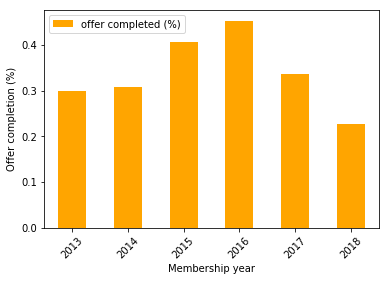

In [16]:
# -------------------------------------------------------------
# Check dependency between offer completion and membership year
# -------------------------------------------------------------

df1 = df.groupby(['became_member_on'])['Offer completed'].mean().reset_index()

x = df1['became_member_on'].values
y = df1['Offer completed'].values

df1 = pd.DataFrame({'became_member_on':x, 'offer completed (%)':y})
ax = df1.plot.bar(x='became_member_on', y='offer completed (%)', rot=45, color = 'orange')

plt.xlabel("Membership year")
plt.ylabel("Offer completion (%)")  

# Outcome
#####################################################################################
# there is no evidence about strong relation between 
# newer/older members and offer completion.
# Maybe we should try and target neither newest members nor the very old ones
# e.g. we could target more persons that became members at 2015-2016
# maybe that means that older members do not need/seek promotions or they don't care
# about them (same for newer members)
# but those in the middle maybe are waiting for them
#####################################################################################



Text(0,0.5,'Offer completion (%)')

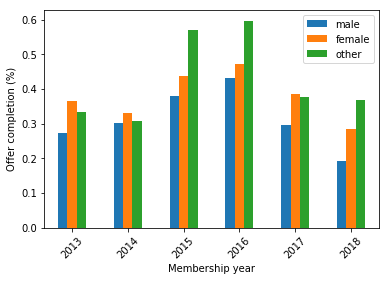

In [17]:
# ------------------------------------------------------------------------
# Check dependency between offer completion per gender and membership year
# ------------------------------------------------------------------------
femaleMembers = df.loc[df['gender'] == 'F']
df1 = femaleMembers.groupby('became_member_on').mean().reset_index()
femaleOfferCompleted = df1['Offer completed'].values

maleMembers = df.loc[df['gender'] == 'M']
df1 = maleMembers.groupby('became_member_on').mean().reset_index()
maleOfferCompleted = df1['Offer completed'].values

otherMembers = df.loc[df['gender'] == 'O']
df1 = otherMembers.groupby('became_member_on').mean().reset_index()
otherOfferCompleted = df1['Offer completed'].values

membershipYears = df1['became_member_on'].values

df1 = pd.DataFrame({'male':maleOfferCompleted,
                   'female':femaleOfferCompleted,
                   'other':otherOfferCompleted
                   }, index = membershipYears)

ax = df1.plot.bar(rot=45)
plt.xlabel("Membership year")
plt.ylabel("Offer completion (%)")   


# ===================================================================
# Observation
# ===================================================================
# It seems that in 2015 & 2016 there had been observed an increase
# in offer accedtance for all genres. 
# But the rise was really significant for customers declaring "other" 
# as gender type
# ===================================================================
#             2013      2014      2015      2016      2017      2018
# male    0.273249  0.301709  0.379465  0.432944  0.297279  0.192511
# female  0.366366  0.331683  0.438876  0.470905  0.385289  0.283776
# other   0.333333  0.307692  0.569106  0.597015  0.376404  0.369748
# ===================================================================

In [18]:
# Classifiers Part 

In [19]:
df1 = df

# replace offer type values: bogo = 0, discount = 1, informational = 2
df1 = df1.replace('bogo',0, regex=True)
df1 = df1.replace('discount',1, regex=True)
df1 = df1.replace('informational',2, regex=True)

# replace gender values: male = 0, female = 1, other = 2
df1 = df1.replace('M',0, regex=True)
df1 = df1.replace('F',1, regex=True)
df1 = df1.replace('O',2, regex=True)

df1.head()

,Offer type,Offer completed,age,became_member_on,gender,income
0,0,1,75,2017,1,100000.0
1,2,0,75,2017,1,100000.0
2,0,1,75,2017,1,100000.0
3,0,0,75,2017,1,100000.0
4,1,0,68,2018,0,70000.0


In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Prepare Input data 
X = df1.drop(columns=['Offer completed']).values

# Prepare Output data
y = df1['Offer completed'].values

# Create train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20) 

# Transform data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test) 

In [25]:
# Find best params for KNeighborsClassifier

grid_params = {
    'n_neighbors':[3,5,11,19],
    'weights' : ['uniform','distance'],
    'metric':['euclidean', 'manhattan']
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    cv = 3,
    n_jobs = -1,
    scoring='accuracy', 
    verbose=10)

gs_results = gs.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",gs_results.best_estimator_)
print("\n The best score across ALL searched params:\n",gs_results.best_score_)
print("\n The best parameters across ALL searched params:\n",gs_results.best_params_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................
[CV]  metric=euclidean, n_neighbors=3, weights=uniform, score=0.6637630662020906, total=   0.7s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=3, weights=uniform, score=0.6637240097572308, total=   0.6s
[CV] metric=euclidean, n_neighbors=3, weights=uniform ................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=3, weights=uniform, score=0.6702288302938785, total=   0.7s
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    5.4s remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=3, weights=distance, score=0.6656794425087108, total=   0.3s
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    6.2s remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=3, weights=distance, score=0.6670344987803462, total=   0.3s
[CV] metric=euclidean, n_neighbors=3, weights=distance ...............


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.9s remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=3, weights=distance, score=0.6712742478801255, total=   0.3s
[CV] metric=euclidean, n_neighbors=5, weights=uniform ................


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    7.7s remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=5, weights=uniform, score=0.6696864111498257, total=   0.7s
[CV] metric=euclidean, n_neighbors=5, weights=uniform ................


[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    9.6s remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=5, weights=uniform, score=0.6689510976884656, total=   0.7s
[CV] metric=euclidean, n_neighbors=5, weights=uniform ................


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   11.5s remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=5, weights=uniform, score=0.6745847369032408, total=   0.7s
[CV] metric=euclidean, n_neighbors=5, weights=distance ...............


[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   13.5s remaining:    0.0s


[CV]  metric=euclidean, n_neighbors=5, weights=distance, score=0.6688734030197445, total=   0.4s
[CV] metric=euclidean, n_neighbors=5, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=5, weights=distance, score=0.6708096178417935, total=   0.4s
[CV] metric=euclidean, n_neighbors=5, weights=distance ...............
[CV]  metric=euclidean, n_neighbors=5, weights=distance, score=0.6733070042978279, total=   0.4s
[CV] metric=euclidean, n_neighbors=11, weights=uniform ...............
[CV]  metric=euclidean, n_neighbors=11, weights=uniform, score=0.6821138211382114, total=   0.8s
[CV] metric=euclidean, n_neighbors=11, weights=uniform ...............
[CV]  metric=euclidean, n_neighbors=11, weights=uniform, score=0.6775467533976072, total=   0.8s
[CV] metric=euclidean, n_neighbors=11, weights=uniform ...............
[CV]  metric=euclidean, n_neighbors=11, weights=uniform, score=0.6855035428040422, total=   0.8s
[CV] metric=euclidean, n_neighbors=11, weights=distance .......

[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  1.3min finished


In [26]:
# Train classifier based on the best parameters found
# and predict on test data
classifier = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
           metric_params=None, n_jobs=-1, n_neighbors=19, p=2,
           weights='uniform')

classifier.fit(X_train, y_train) 

# Predict y data with classifier: 
y_predict = classifier.predict(X_test)

# Print results: 
cf_matrix = confusion_matrix(y_test, y_predict)
print("---------------------------------------------------------------")
print("Confusion Matrix")
print(cf_matrix)
print("---------------------------------------------------------------")
print("Classification Report")
print(classification_report(y_test, y_predict)) 

# ===================================================================
# Observation
# ===================================================================
# KNN classifier manages to predict 68% in average the people that will
# complete or not an offer
# Actually we got a 74% precision rate for people that will not accept
# offers, so it is safer to trust the model mostly in order to avoid
# sending offers to specific customers


---------------------------------------------------------------
Confusion Matrix
[[6941 1539]
 [2571 1864]]
---------------------------------------------------------------
Classification Report
             precision    recall  f1-score   support

          0       0.73      0.82      0.77      8480
          1       0.55      0.42      0.48      4435

avg / total       0.67      0.68      0.67     12915



In [27]:
# Find best params for DecisionTreeClassifier

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
tree_clas = DecisionTreeClassifier(random_state=1024)
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train, y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
 Results from Grid Search 

 The best estimator across ALL searched params:
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1024,
            splitter='best')

 The best score across ALL searched params:
 0.696085643488

 The best parameters across ALL searched params:
 {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto'}


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    5.3s finished


In [28]:
# Train classifier based on the best parameters found
# and predict on test data
classifier = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1024,
            splitter='best')
classifier.fit(X_train, y_train) 


# Predict y data with classifier: 
y_predict = classifier.predict(X_test)

# Print results: 
cf_matrix = confusion_matrix(y_test, y_predict)
print("---------------------------------------------------------------")
print("Confusion Matrix")
print(cf_matrix)
print("---------------------------------------------------------------")
print("Classification Report")
print(classification_report(y_test, y_predict)) 

# ===================================================================
# Observation
# ===================================================================
# DecisionTreeClassifier classifier manages to predict 69% in average 
# the people that will complete or not an offer
# Actually we got a 75% precision rate for people that will not accept
# offers, so it is safer to trust the model mostly in order to avoid
# sending offers to specific customers

---------------------------------------------------------------
Confusion Matrix
[[6987 1493]
 [2481 1954]]
---------------------------------------------------------------
Classification Report
             precision    recall  f1-score   support

          0       0.74      0.82      0.78      8480
          1       0.57      0.44      0.50      4435

avg / total       0.68      0.69      0.68     12915



In [ ]:
# =====================================================================
# General Observation
# =====================================================================
# Both classifiers achieve a prediction rate of about 70%. They perform
# better at predicting people that will not accept offers, than those 
# that will accept them